# 提醒

In [44]:
"""debug example"""
# for i in [1,2,3,4,5]:
#     print(i)
    #import ipdb; ipdb.set_trace() # debugging starts here
    # http://frid.github.io/blog/2014/06/05/python-ipdb-cheatsheet/

'debug example'

# Part I :Tsay ,Analysis of Financial Time Series, 2nd Edition
## Implementation for the formula in the book

In [3]:
import random

import matplotlib.pyplot as plt
import numpy as np

from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns

In [4]:
random.seed(9)


## Weiner Process and other random processes

 <img src="wiener_process.png"> 

### define the random processes and some useful utils

In [1]:
def white_noise(period = 100,distribution='uniform'):
    if distribution == 'uniform':
        return np.array([random.uniform(-1,1) for i in range(period)])
    
def random_walk(period = 100,initial=0):
    rw=[0]*period
    rw[0]=initial
    for i in range(1,100):
        rw[i]=rw[i-1]+random.gauss(0,1)
    return np.array(rw)

def ar1(period=100,initial=0):
    ar1=[0]*period
    ar1[0]=initial
    for i in range(1,100):
        ar1[i]=0.5*ar1[i-1]+random.gauss(0,1)
    return np.array(ar1)

def plot(curve,period=100,step=1.0):
    plt.plot(np.array([i/step for i in range(period)]),curve)
    plt.show()

# autocorrelation function (ACF)
#vectorized version
def acf(series,lag=1):
    mean = np.mean(series)
    acf = np.sum(np.multiply(series[:-1-lag],series[lag:-1]))/np.sum(np.square(series))
    return acf
        
def acf_curve(series,lag=15,figsize=(6,0.5)):
    plt.figure(num=None, figsize=figsize, dpi=80, facecolor='w', edgecolor='k')
    acf_curve = np.array([acf(series,i) for i in range(1,lag+1)])
    plt.plot(np.array(range(1,lag+1)),acf_curve)
    plt.show()

def wiener_process(period =100,n=1000,initial=0):
    t=period
    wp=[0]*t*n
    wp[0]=initial
    
    for i in range(1,t*n):
        wp[i]=wp[i-1]+random.gauss(0,1)/np.sqrt(n)
    return np.array(wp),t,n

### Demo: autoregressive in 1st order

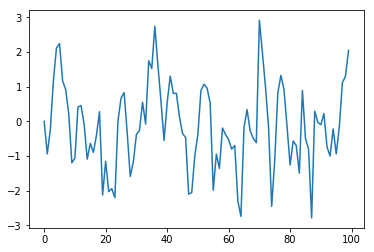

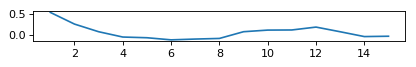

In [5]:
plot(ar1())
acf_curve(ar1())

### Demo: Random Walk

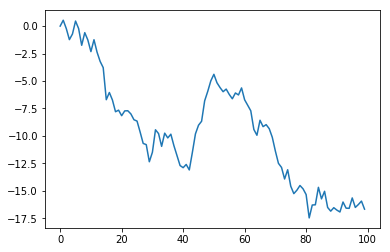

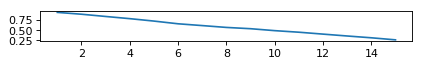

In [104]:
plot(random_walk())
acf_curve(random_walk())

### Demo: White Noise

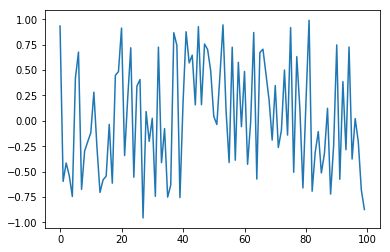

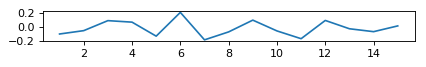

In [103]:
plot(white_noise())
acf_curve(white_noise())

### Demo: Wiener Process

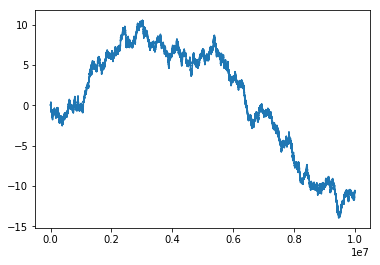

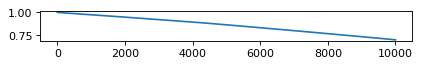

In [102]:
wiener_process,t,n=wiener_process()
plot(wiener_process,t*n,step=1/t)
acf_curve(wiener_process,lag=10000)

### Box-Ljung Test

 <img src="BoxLjung.png"> 

In [108]:
def BoxLjung(series,m):
    acfs = np.array([acf(series,i) for i in range(1,m+1)])
    dfs = np.array([len(series)-i for i in range(1,m+1)])
    term = np.divide(np.square(acfs),dfs)
    return len(series)*(len(series)+2)*np.sum(term)
    

BoxLjung(random_walk(),1)#75.26977166558552
BoxLjung(white_noise(),3)#5.7223008091166685

## Part II : Empirical Study
   - Fetch the historical quote price
   - Fit the curve with time series model
   - Out-sample Forcasting

In [10]:
# Dow Jones
param = {
    'q': ".DJI", # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    'x': "INDEXDJX", # Stock exchange symbol on which stock is traded (ex: "NASD")
    'p': "1Y" # Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
df = get_price_data(param)

# fit dow jones with arma model
train,test=df['Close'].iloc[:200].values,df['Close'].iloc[200:].values
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit()
	# one step forecast
	yhat = model_fit.forecast()[0]
	# store forecast and ob
	predictions.append(yhat)
	history.append(test[t])

np.random.seed(sum(map(ord, "aesthetics")))
sns.set()
plt.figure(figsize=((4,3)))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

model_fit.params#15.70817966,   0.0690629 ,  -0.25063078,   0.22580679,  -0.02755417


## Daw-Jones Historical Prices and its Autocovariance

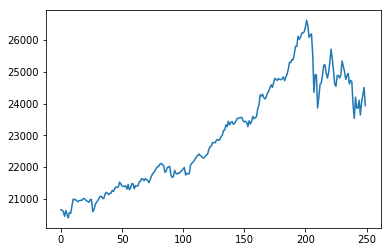

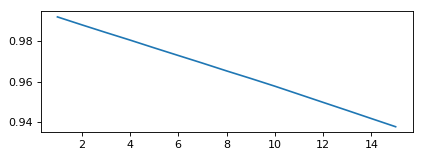

In [136]:
dji_close = df['Close'].values
plot(dji_close,len(dji_close)) # 1Y-trend
acf_curve(dji_close,figsize=(6,2)) #there are some bugs
#                          Open      High       Low     Close     Volume
# 2016-05-17 05:00:00  17531.76   17755.8  17531.76  17710.71   88436105
# 2016-05-18 05:00:00  17701.46  17701.46  17469.92  17529.98  103253947
# 2016-05-19 05:00:00  17501.28  17636.22  17418.21  17526.62   79038923
# 2016-05-20 05:00:00  17514.16  17514.16  17331.07   17435.4   95531058
# 2016-05-21 05:00:00  17437.32  17571.75  17437.32  17500.94  111992332
# ...                       ...       ...       ...       ...        ...

## Fetch Other Quote Data

In [ ]:
params = [
    # Dow Jones
    {
        'q': ".DJI",
        'x': "INDEXDJX",
    },
    # NYSE COMPOSITE (DJ)
    {
        'q': "NYA",
        'x': "INDEXNYSEGIS",
    },
    # S&P 500
    {
        'q': ".INX",
        'x': "INDEXSP",
    }
]
period = "1Y"
# get open, high, low, close, volume data (return pandas dataframe)
df = get_prices_data(params, period)
print(df)
#            .DJI_Open  .DJI_High  .DJI_Low  .DJI_Close  .DJI_Volume  \
# 2016-07-20   18503.12   18562.53  18495.11    18559.01    85840786
# 2016-07-21   18582.70   18622.01  18555.65    18595.03    93233337
# 2016-07-22   18589.96   18590.44  18469.67    18517.23    86803016
# 2016-07-23   18524.15   18571.30  18491.59    18570.85    87706622
# 2016-07-26   18554.49   18555.69  18452.62    18493.06    76807470
# ...               ...        ...       ...         ...         ...

params = [
    # Dow Jones
    {
        'q': ".DJI",
        'x': "INDEXDJX",
    },
    # NYSE COMPOSITE (DJ)
    {
        'q': "NYA",
        'x': "INDEXNYSEGIS",
    },
    # S&P 500
    {
        'q': ".INX",
        'x': "INDEXSP",
    }
]
period = "1Y"
interval = 60*30 # 30 minutes
# get open, high, low, close, volume time data (return pandas dataframe)
df = get_prices_time_data(params, period, interval)
print(df[:50])
#                      .DJI_Open  .DJI_High  .DJI_Low  .DJI_Close  .DJI_Volume  \
# 2016-07-19 23:00:00   18503.12   18542.13  18495.11    18522.47            0
# 2016-07-19 23:30:00   18522.44   18553.30  18509.25    18546.27            0
# 2016-07-20 00:00:00   18546.20   18549.59  18519.77    18539.93            0
# 2016-07-20 00:30:00   18540.24   18549.80  18526.99    18534.18            0
# 2016-07-20 01:00:00   18534.05   18540.38  18507.34    18516.41            0
# ...                        ...        ...       ...         ...          ...

# Part III: Applied Financial Time Series Analysis 
## Lecture Note for Chapter 2

- in-sample period / out-of-sample period (holdback period)

- recursive / rolling window
    

$$ E_{T_0}[y_{t_{0+j}}] $$
$$ E_{T_1}[y_{t_{1+j}}] $$

- MSPE(mean sqaure prediction error)
$$MSPE_i = \frac{1}{H} \sum_{t=1}^H e_{it}^2$$
    - e is prediction error
     
- Diebold-Mariano test
<img src='diebold_mariano.png'height="200" width="400">

    - if H is not large enough, use bootstrap or Monte Carlo

- 利用差分確認資料的持續性 
    - 波動度一直在變的資料不適合用ARMA

- Chow test (detect structural change)